In [54]:
import zipfile
import os
import pandas as pd
import numpy as np
import pathlib
import xarray as xr
import netCDF4 as nc
import dask
import json
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import shap
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [122]:
# import csv file
df = pd.read_csv('/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/penguins_final_with_era5.csv')

In [123]:
print(df.head())

   Unnamed: 0           track_id    date_gmt  ...   sd        rsn  avg_smr
0           0  1330_153797_79904  2016-11-10  ...  0.0  99.999992      0.0
1           1  1330_153797_79904  2016-11-11  ...  0.0  99.999992      0.0
2           2  1330_153797_79904  2016-11-19  ...  0.0  99.999992      0.0
3           3  1330_153797_79904  2016-11-20  ...  0.0  99.999992      0.0
4           4  1330_153797_79904  2017-02-06  ...  0.0  99.999992      0.0

[5 rows x 57 columns]


In [124]:
df = df.drop(columns=['Unnamed: 0'])

In [127]:
# filter for adelie penguins
df_adelie = df[df['common_name'] == 'Adelie Penguin']

In [128]:
df_adelie['date_gmt'] = pd.to_datetime(df_adelie['date_gmt'])

df_adelie['year'] = df_adelie['date_gmt'].dt.year
df_adelie['month'] = df_adelie['date_gmt'].dt.month

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63346/4269786950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adelie['date_gmt'] = pd.to_datetime(df_adelie['date_gmt'])
/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63346/4269786950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adelie['year'] = df_adelie['date_gmt'].dt.year
/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63346/4269786950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [129]:
# group by month and year
df_adelie_meaned = df_adelie.groupby(['year', 'month']).mean()

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63346/1036145953.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_adelie_meaned = df_adelie.groupby(['year', 'month']).mean()


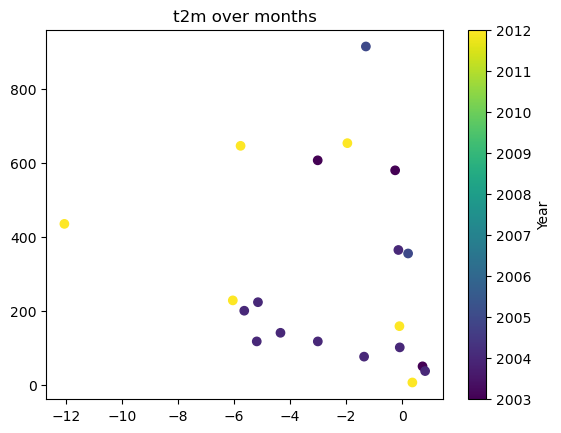

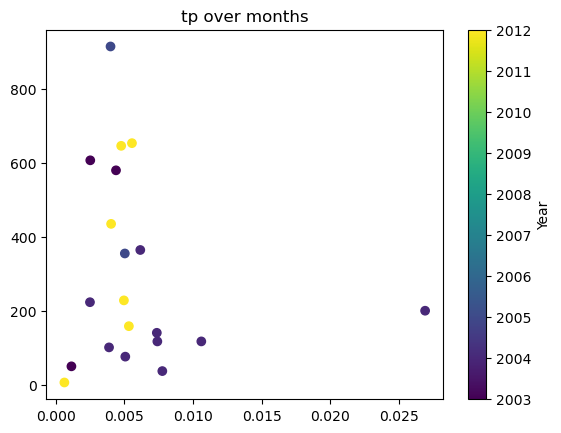

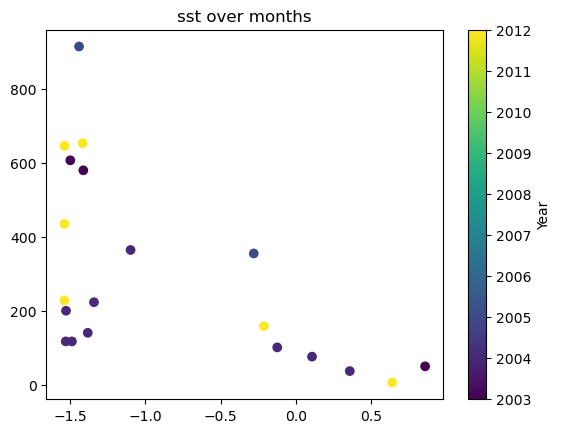

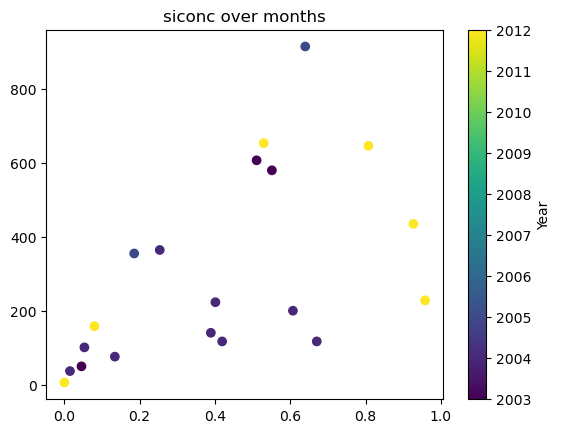

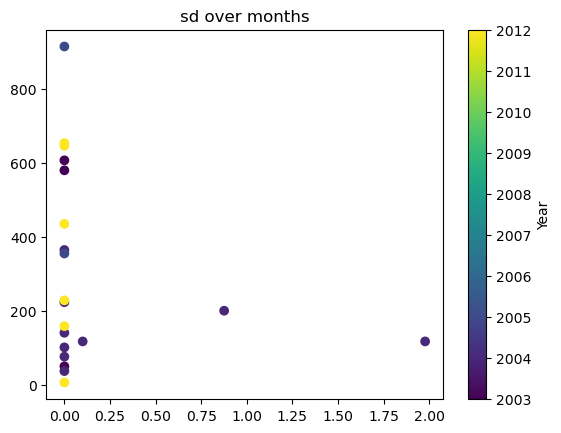

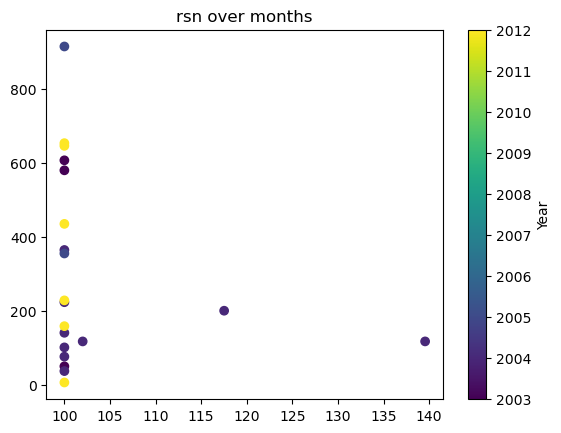

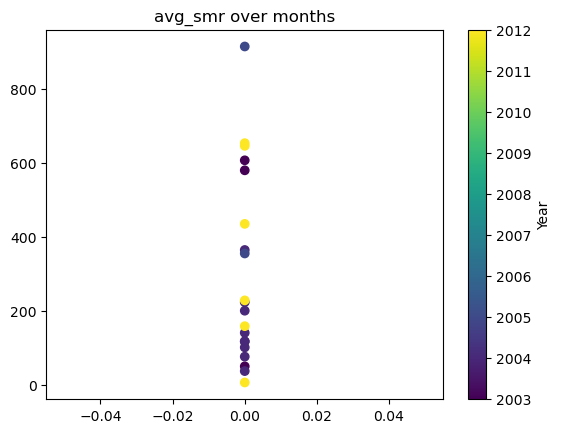

In [130]:
# plot siconc against km_to_colony_mean
target_variables = ['t2m', 'tp', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']

years = [
    2003, 2004, 2005, 2012]

def plot_test(df, target_variable, years,deg):
    # Reset index to access year and month as columns
    df = df.reset_index()
    df = df[df['year'].isin(years)]
    for variable in target_variable:
        plt.figure()
        scatter = plt.scatter( df[variable], df['km_to_colony_mean'],
                        c=df['year'], cmap='viridis')
        plt.colorbar(scatter, label='Year')

     # add regression line
        # z = np.polyfit(df[variable], df['km_to_colony_mean'], deg)   # Hier 1, 2, 3, oder 4 degs rein?
        # p = np.poly1d(z)
        # plt.plot(df['year'],p(df['year']), linestyle = "-", c = 'red', linewidth = 0.3)

        # plt.ylabel('km_to_colony_mean')
        # plt.xlabel(variable)
        plt.title(f'{variable} over months')
        plt.show()

plot_test(df_adelie_meaned, target_variables, years, 2)

In [131]:
print(df_adelie.columns)

Index(['track_id', 'date_gmt', 'latitude_mean', 'longitude_mean',
       'lat_colony_mean', 'lon_colony_mean', 'km_to_colony_mean',
       'km_since_last_measure_mean', 'delta_km_north_mean',
       'delta_km_south_mean', 'delta_km_east_mean', 'delta_km_west_mean',
       'minutes_since_last_measure_mean', 'latitude_std', 'longitude_std',
       'lat_colony_std', 'lon_colony_std', 'km_to_colony_std',
       'km_since_last_measure_std', 'delta_km_north_std', 'delta_km_south_std',
       'delta_km_east_std', 'delta_km_west_std',
       'minutes_since_last_measure_std', 'latitude_min', 'longitude_min',
       'lat_colony_min', 'lon_colony_min', 'km_to_colony_min',
       'km_since_last_measure_min', 'delta_km_north_min', 'delta_km_south_min',
       'delta_km_east_min', 'delta_km_west_min',
       'minutes_since_last_measure_min', 'latitude_max', 'longitude_max',
       'lat_colony_max', 'lon_colony_max', 'km_to_colony_max',
       'km_since_last_measure_max', 'delta_km_north_max', 'delta

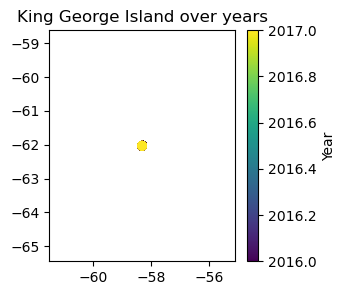

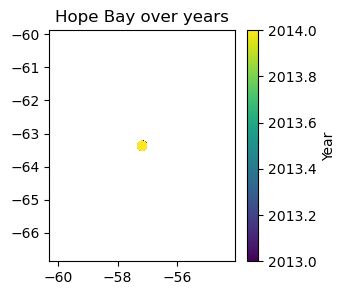

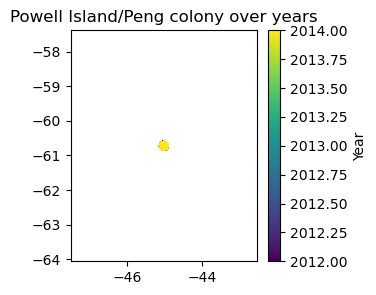

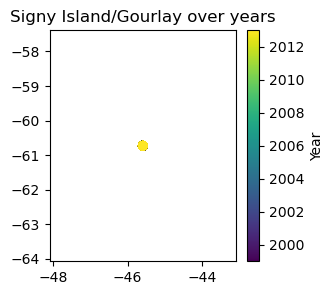

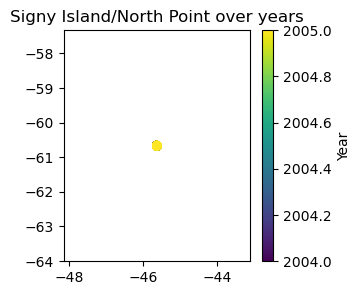

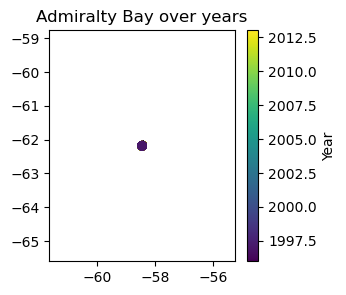

In [134]:
# plot lat_colony_mean and lon_colony_mean against year for each colony

colonies = df_adelie['colony_name'].unique()

for colony in colonies:
    plt.figure(figsize=(3, 3))
    plt.scatter(df_adelie[df_adelie['colony_name'] == colony]['lon_colony_mean'], df_adelie[df_adelie['colony_name'] == colony]['lat_colony_mean'], cmap='viridis', c=df_adelie[df_adelie['colony_name'] == colony]['year'])
    plt.colorbar(label='Year')
    plt.title(f'{colony} over years')
    plt.show()

- colonies do not move (at least we did not find a movement here)

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63346/1710706402.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_adelie.corr()


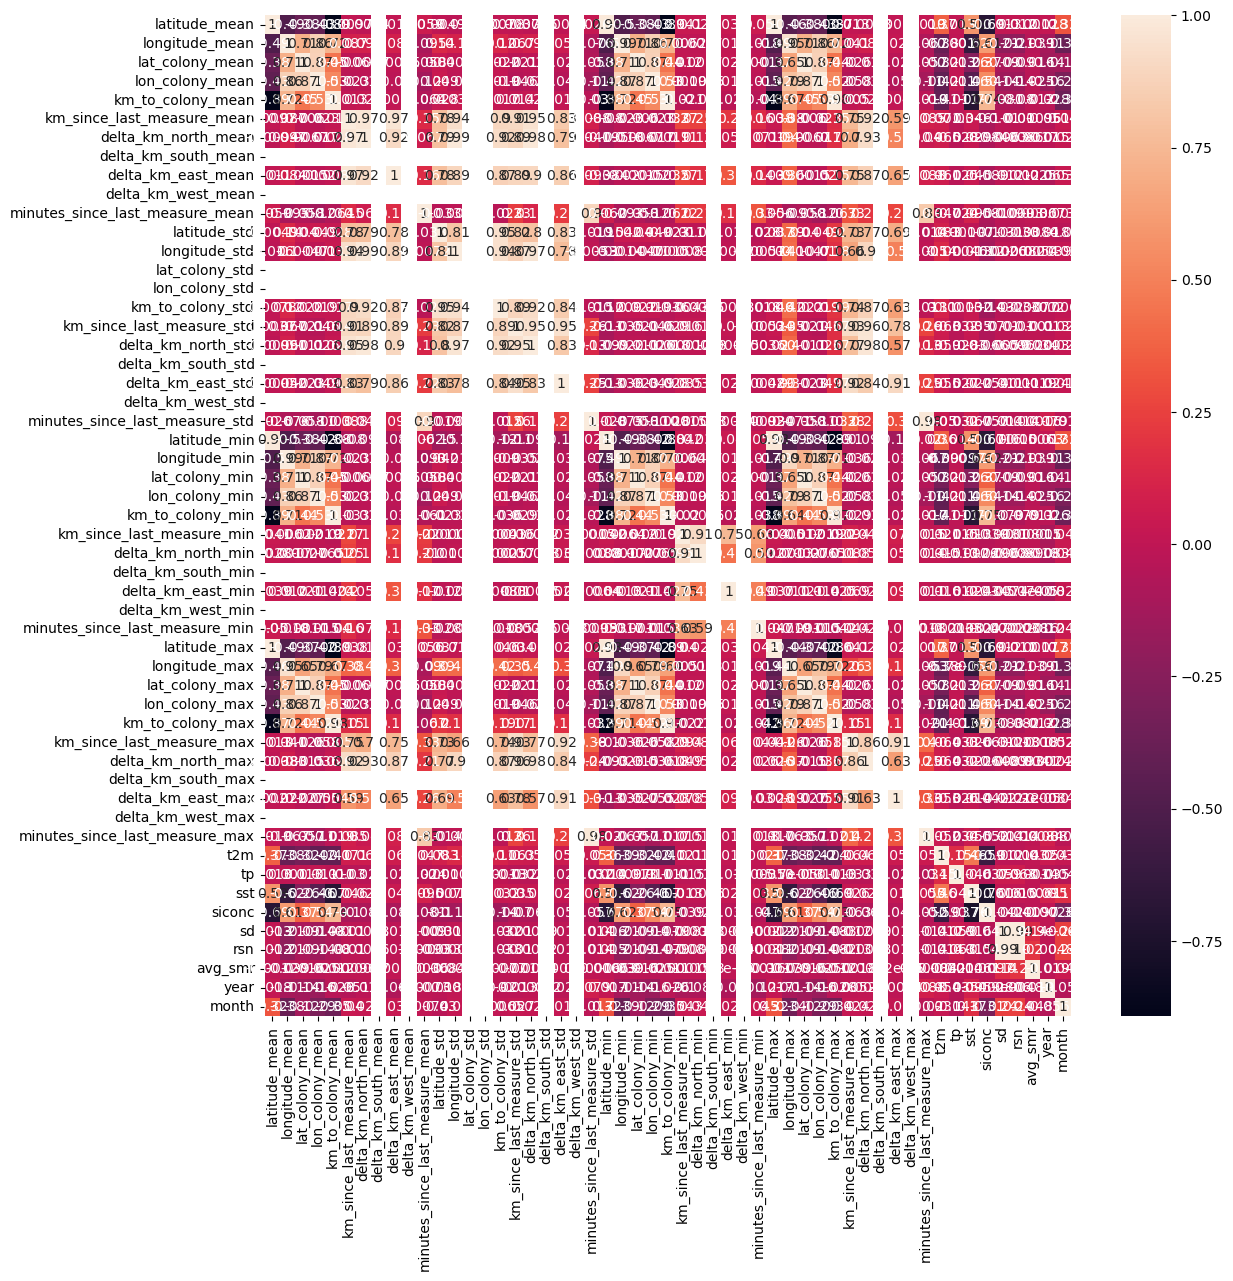

In [135]:
# correlation between sst and km_to_colony_mean
corr = df_adelie.corr()

plt.figure(figsize=(13, 13))
sns.heatmap(corr, annot=True)
plt.show()


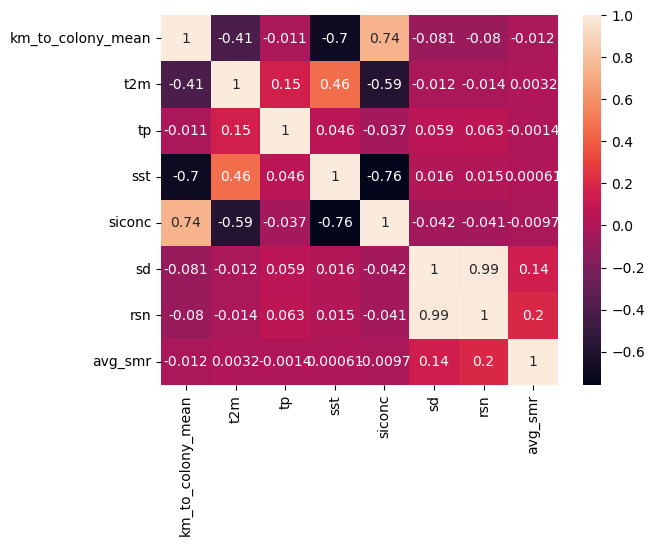

In [136]:
# correlation between sst and km_to_colony_mean
df_adelie_reduced = df_adelie[['km_to_colony_mean', 't2m', 'tp', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']]
corr = df_adelie_reduced.corr()

# plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True)
plt.show()


- sd, smr, and year dont show strong correlations
- month shows correlaton with km to colony mean and siconc in similar fashion
    - omit them because they do not bring any value
    - limit to 

## try random forest and xgboost model only with those variables
t2m, sst, siconc

In [106]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [162]:
columns = df_adelie.columns

def pca(df, columns, n_components=None):
    df_pca = df[columns]
    df_pca = df_pca.select_dtypes(include=[float, int]) 
    
    df_pca = df_pca.dropna()

    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    df_pca_scaled = scaler.fit_transform(df_pca)
    
    # Apply PCA
    pca = PCA(n_components=n_components)  # Optionally, choose how many components to keep
    pca.fit(df_pca_scaled)  # Fit the PCA model

    # Transform the data into principal components
    transformed_data = pca.transform(df_pca_scaled)  # This is the data with the reduced features
    
    # Extract explained variance ratio
    explained_variance = pca.explained_variance_ratio_  # Variance explained by each component

    return transformed_data, explained_variance, pca.components_

In [148]:

# df_adelie = df_adelie.drop(columns=['track_id', 'common_name', 'site_name', 'colony_name'])
print(df_adelie.head())

    date_gmt  latitude_mean  longitude_mean  ...  avg_smr  year  month
0 2016-11-10     -62.265289      -58.567748  ...      0.0  2016     11
1 2016-11-11     -62.257840      -58.615930  ...      0.0  2016     11
2 2016-11-19     -62.263328      -58.613830  ...      0.0  2016     11
3 2016-11-20     -62.279008      -58.622599  ...      0.0  2016     11
4 2017-02-06     -63.645865      -52.717015  ...      0.0  2017      2

[5 rows x 54 columns]


In [149]:
columns = df_adelie.columns
transformed_data, explained_variance, components = pca(df_adelie, columns)

# make model with transformed data                                                                          

TypeError: random_forest() missing 1 required positional argument: 'features'

In [150]:
# group df_adelie_dropped by track_id
df_adelie_id = df_adelie_dropped.groupby('track_id').mean().reset_index(drop=True)

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_63346/153845010.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_adelie_id = df_adelie_dropped.groupby('track_id').mean().reset_index(drop=True)


In [24]:
def data_prep(df):

    # check if date_gmt exists in dataframe
    if 'date_gmt' in df.columns:
        df['date_gmt'] = pd.to_datetime(df['date_gmt'])
        df = df.sort_values(by='date_gmt')
    else:
        pass

    # Drop rows with missing values
    df = df.dropna()

    return df

In [25]:

def splitting(df):
    # Define feature set and target variable
    features = [
        't2m', 'sst', 'siconc'
    ]
    target = 'km_to_colony_mean'

    X = df[features]
    y = df[target]

    # Train-test split (e.g., last 20% for testing)
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    return X_train, X_test, y_train, y_test, features, target

In [26]:
def hyperopt_rf(Xtrain, ytrain):
    def objective(params):
        """
        Objective function for Hyperopt to minimize.
        """
        rf = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        # tscv = TimeSeriesSplit(n_splits=5)  # Use Time Series CV
        # do not use time series split, but normal cv
        tscv = 10

        scores = -cross_val_score(rf, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        return {'loss': np.mean(scores), 'status': STATUS_OK}

    # Define the search space
    space = {
        'n_estimators': hp.choice('n_estimators', [100, 200, 300, 500]),
        'max_depth': hp.choice('max_depth', [None]),
        'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.1),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.1),
        'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
    }

    # Perform the optimization
    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    # Print the best hyperparameters
    print("Best Hyperparameters:", best_params)

    return best_params


In [27]:
def training_rf(Xtrain, ytrain, best_params):    
    # Map the best parameters from Hyperopt
    final_params = {
        'n_estimators': [50, 100, 200, 300, 500][best_params['n_estimators']],
        'max_depth': [5, 10, 15, 20, 100][best_params['max_depth']],
        'min_samples_split': best_params['min_samples_split'],
        'min_samples_leaf': best_params['min_samples_leaf'],
        'max_features': ['sqrt', 'log2', None][best_params['max_features']],
        'random_state': 42,
        'n_jobs': -1
    }

    # Train the Random Forest model
    rf_model = RandomForestRegressor(**final_params)
    rf_model.fit(Xtrain, ytrain)

    return rf_model

def evaluate_rf(Xtest, ytest, model, features):
    # Evaluate the model
    y_pred = model.predict(Xtest)
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    r2 = r2_score(ytest, y_pred)
    print(f"Random Forest Test RMSE: {rmse:.3f}")
    print(f"Random Forest Average R^2 Score: {r2:.3f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_,
    }).sort_values(by='Importance', ascending=False)
    print(feature_importance)

    return rmse, r2, feature_importance

In [28]:
def shapValues(model, data):
    # Create SHAP explainer
    explainer = shap.Explainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(data)

    # Summary plot
    shap.summary_plot(shap_values, data)

    # # Dependence plot for a specific feature
    # shap.dependence_plot('sst', shap_values, interaction_index="Deaths per min.")

In [29]:
def random_forest(Xtrain, Xtest, ytrain, ytest, features):
    
    best_params = hyperopt_rf(Xtrain, ytrain)
    model = training_rf(Xtrain, ytrain, best_params)
    rmse, r2, feature_importance = evaluate_rf(Xtest, ytest, model, features)

    return best_params, model, rmse, r2, feature_importance

In [30]:
def run_model(df, corr_plot = True):

    #Preprocessing
    prep_df = data_prep(df)

    features = [
            't2m', 'sst', 'siconc'
        ]

    # Correlation analysis
    correlation = prep_df[features].corr(method="spearman")  # Spearman for monotonic relationships
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, annot_kws={'size': 7}, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Spearman Correlation")
    plt.show()

    # Splitting training and testing data
    X_train, X_test, y_train, y_test, features, target = splitting(prep_df)

    # Random Forest
    best_params_rf, model_rf ,rmse_rf, r2_rf, feature_importance_rf = random_forest(X_train, X_test, y_train, y_test, features)

    # SHAP Values
    shapValues(model_rf, X_test)

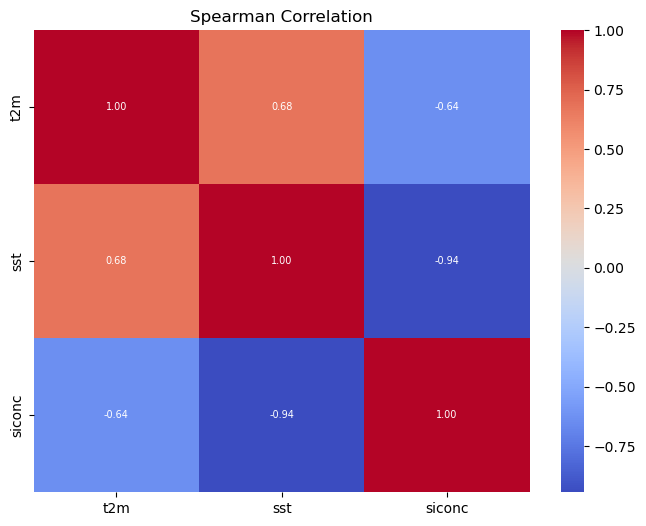

100%|██████████| 50/50 [01:49<00:00,  2.19s/trial, best loss: 36004.26440600893]
Best Hyperparameters: {'max_depth': 3, 'max_features': 0, 'min_samples_leaf': 0.010722376795684004, 'min_samples_split': 0.04179591719548655, 'n_estimators': 2}
Random Forest Test RMSE: 113.003
Random Forest Average R^2 Score: 0.620
  Feature  Importance
1     sst    0.465682
2  siconc    0.369754
0     t2m    0.164565


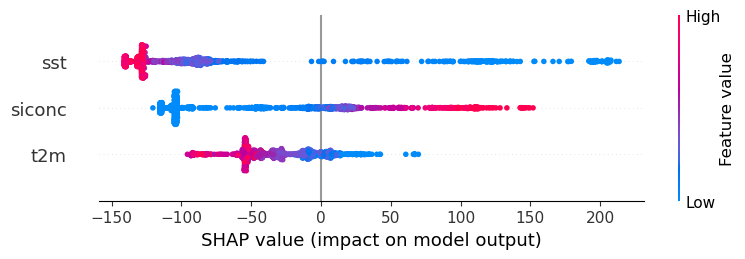

In [115]:
run_model(df_adelie_dropped)

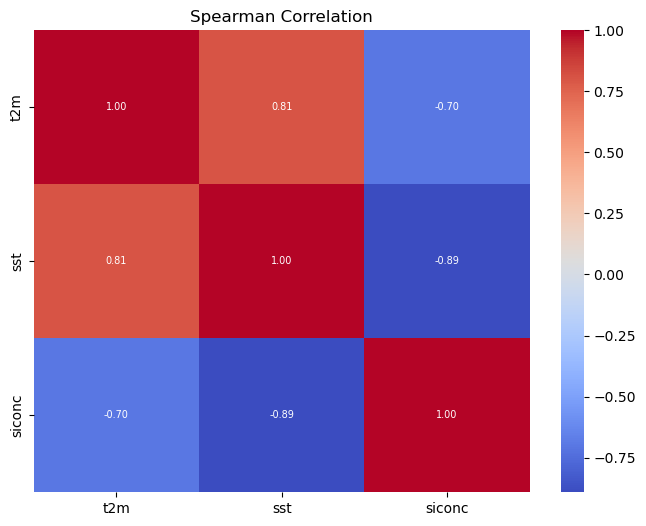

100%|██████████| 50/50 [00:44<00:00,  1.13trial/s, best loss: 18007.342919452047]
Best Hyperparameters: {'max_depth': 0, 'max_features': 2, 'min_samples_leaf': 0.09991694557624088, 'min_samples_split': 0.033014789643723196, 'n_estimators': 1}
Random Forest Test RMSE: 100.431
Random Forest Average R^2 Score: 0.548
  Feature  Importance
2  siconc    0.979056
0     t2m    0.020077
1     sst    0.000867


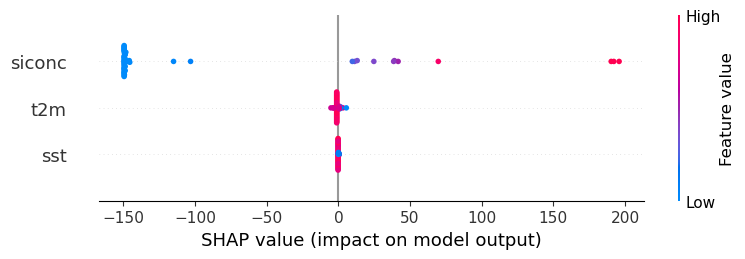

In [120]:
run_model(df_adelie_id)

In [31]:
print(df_adelie_id.head())

   km_to_colony_mean       t2m       sst    siconc
0         251.129569 -0.377521 -0.844947  0.209797
1          69.971722 -1.853851 -0.681267  0.021571
2         244.717962 -0.404334 -0.761249  0.168207
3         323.460771 -0.696449 -1.140584  0.505567
4         266.930052 -0.773172 -1.210058  0.587204


In [32]:


print(df_adelie_id.head())

   km_to_colony_mean       t2m       sst    siconc
0         251.129569 -0.377521 -0.844947  0.209797
1          69.971722 -1.853851 -0.681267  0.021571
2         244.717962 -0.404334 -0.761249  0.168207
3         323.460771 -0.696449 -1.140584  0.505567
4         266.930052 -0.773172 -1.210058  0.587204


## Try xgboost



In [44]:
def hyperopt_xgb(Xtrain, ytrain):
    def objective(params):
        """
        Objective function for Hyperopt to minimize.
        """
        model = xgb.XGBRegressor(
            **params,
            objective='reg:squarederror',
            random_state=42,
            # tree_method='hist'  # Optimized for speed
        )
        
        # tscv = TimeSeriesSplit(n_splits=5)  # Time Series Cross-Validation
        tscv = 10
        scores = -cross_val_score(model, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        
        return {'loss': np.mean(scores), 'status': STATUS_OK}

    # Define the search space
    space = {
        'n_estimators': hp.choice('n_estimators', [100, 200, 500, 1000]),
        'max_depth': hp.choice('max_depth', [3, 5, 7, 10, 30]),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
        'gamma': hp.uniform('gamma', 0, 5),
        'min_child_weight': hp.uniform('min_child_weight', 0.1, 10)
    }

    # Perform optimization
    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    # Print best hyperparameters
    print("Best Hyperparameters:", best_params)

    return best_params

In [45]:
def training_xgb(Xtrain, ytrain, best_params):
    # Map the best hyperparameters
    final_params = {
        'n_estimators': [100, 200, 500, 1000][best_params['n_estimators']],
        'max_depth': [3, 5, 7, 10, 30][best_params['max_depth']],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'min_child_weight': best_params['min_child_weight'],
        'objective': 'reg:squarederror',
        'random_state': 42,
        'tree_method': 'hist'  # Optimized for speed
    }

    # Train the final model
    xgb_model = xgb.XGBRegressor(**final_params)
    xgb_model.fit(Xtrain, ytrain)

    return xgb_model

def evaluate_xgb(Xtest, ytest, model, features):

    # Evaluate the model
    y_pred = model.predict(Xtest)
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    r2 = r2_score(ytest, y_pred)
    print(f"XGBoost Test RMSE: {rmse:.3f}")
    print(f"XGBoost Average R^2 Score: {r2:.3f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_,
    }).sort_values(by='Importance', ascending=False)
    print(feature_importance)

    return rmse, r2, feature_importance



In [46]:
def xgboost(Xtrain, Xtest, ytrain, ytest, features):
    
    best_params = hyperopt_xgb(Xtrain, ytrain)
    model = training_xgb(Xtrain, ytrain, best_params)
    rmse, r2, feature_importance = evaluate_xgb(Xtest, ytest, model, features)

    return best_params, model, rmse, r2, feature_importance

In [47]:
def run_model_xgb(df, corr_plot = True):

    #Preprocessing
    prep_df = data_prep(df)

    features = [
            't2m', 'sst', 'siconc'
        ]

    # Correlation analysis
    correlation = prep_df[features].corr(method="spearman")  # Spearman for monotonic relationships
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, annot_kws={'size': 7}, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Spearman Correlation")
    plt.show()

    # Splitting training and testing data
    X_train, X_test, y_train, y_test, features, target = splitting(prep_df)

    # Random Forest
    best_params_xgb, model_xgb ,rmse_xgb, r2_xgb, feature_importance_xgb = xgboost(X_train, X_test, y_train, y_test, features)
    
    # SHAP Values
    shapValues(model_xgb, X_test)

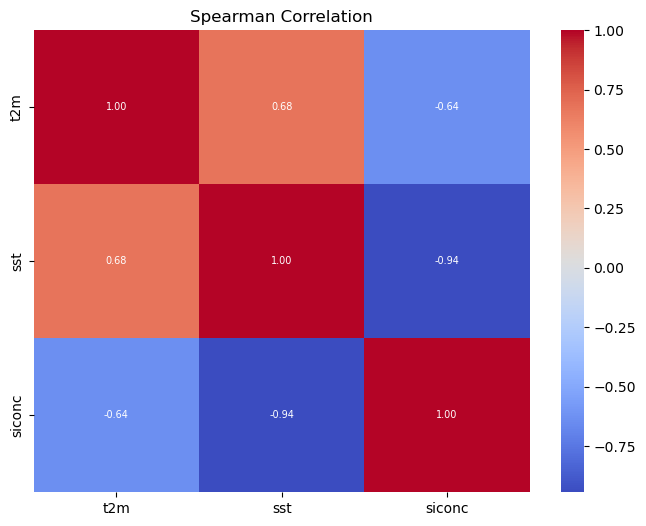

100%|██████████| 50/50 [01:29<00:00,  1.79s/trial, best loss: 36760.442212016584]
Best Hyperparameters: {'colsample_bytree': 0.9042368104117747, 'gamma': 3.4902623889679316, 'learning_rate': 0.014772917706271404, 'max_depth': 1, 'min_child_weight': 9.876436967423555, 'n_estimators': 1, 'subsample': 0.7918505914589234}
XGBoost Test RMSE: 122.395
XGBoost Average R^2 Score: 0.555
  Feature  Importance
1     sst    0.662709
2  siconc    0.287253
0     t2m    0.050039


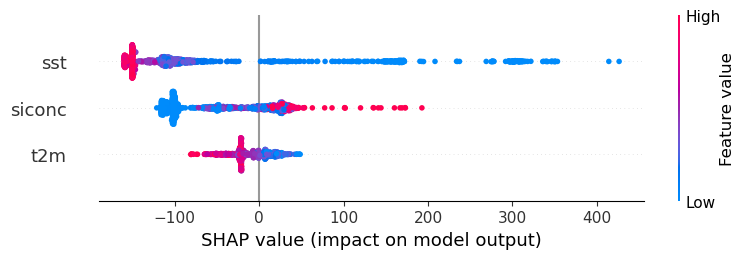

In [48]:
run_model_xgb(df_adelie_dropped)

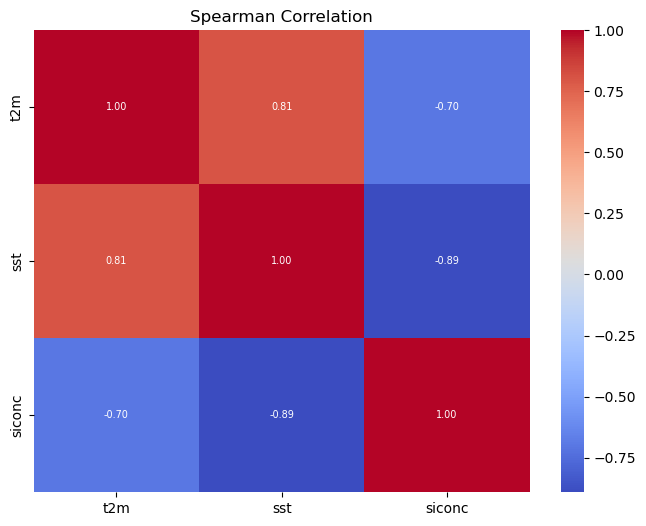

100%|██████████| 50/50 [00:21<00:00,  2.31trial/s, best loss: 19288.480617937083]
Best Hyperparameters: {'colsample_bytree': 0.8644945336565222, 'gamma': 3.291695395116577, 'learning_rate': 0.010647285088148934, 'max_depth': 1, 'min_child_weight': 6.972527429204684, 'n_estimators': 1, 'subsample': 0.7891522438678006}
XGBoost Test RMSE: 100.804
XGBoost Average R^2 Score: 0.545
  Feature  Importance
2  siconc    0.536309
1     sst    0.265031
0     t2m    0.198659


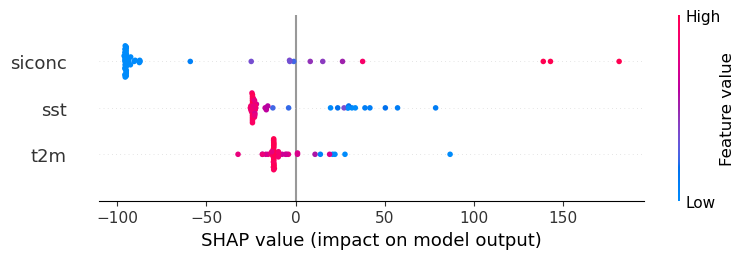

In [49]:
run_model_xgb(df_adelie_id)